In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import classification_report, confusion_matrix



In [222]:
data_photon = pd.read_csv('data/emc_gamma.csv')
data_photon['particle'] = 1 # 'photon'
data_neutron = pd.read_csv('data/emc_neutron.csv')
data_neutron['particle'] = 0 # 'neutron'

In [223]:
data_comb = pd.concat([data_photon, data_neutron], ignore_index=True)
data_random = data_comb.sample(frac = 1, ignore_index = True)

In [224]:
def normalize_split_dataset(
        dataset: pd.DataFrame, 
        selected_features: list[str], 
        label_name: str, 
        test_frac: float = 0.5
        ):

    for feature in selected_features:
        if feature not in dataset.columns.values:
            raise ValueError(f"Feature '{feature}' not present in the dataset.")
        
    if label_name not in dataset.columns.values:
        raise ValueError(f"Label '{label_name}' is not present in the dataset.")

    X = dataset.loc[:, selected_features]
    y = dataset.loc[:, label_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_frac)

    # define scaler based on training data (zero mean, unit std)
    scaler = StandardScaler()
    scaler.fit(X_train)

    # normalize both training and test data using scaler
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return [X_train, X_test, y_train, y_test]

def construct_classifier(train_test_data: list[pd.DataFrame], classifier):
    
    X_train, X_test, y_train, y_test = train_test_data

    classifier.fit(X_train, y_train)

    # test classifier
    y_pred = classifier.predict(X_test)

    # store true and predicted labels for all samples in test data
    y_true_pred = pd.DataFrame()
    y_true_pred["true label"] = y_test
    y_true_pred["predicted label"] = y_pred

    return classifier, y_true_pred

def calculate_FOM(y_true_pred: pd.DataFrame, primary_label):
    if primary_label not in y_true_pred.values:
        raise ValueError("primary label not in true_pred_labels")
    
    # find number of samples which have truely have primary label
    N_true_primaries = len(y_true_pred[y_true_pred['true label'] == primary_label])

    FOM_max = np.sqrt(N_true_primaries)

    # select all samples for which predicted label is primary_label
    pred_primary = y_true_pred[y_true_pred['predicted label'] == primary_label]

    # select samples for which true label is primary label (true positives)
    true_positives = pred_primary[pred_primary['true label'] == primary_label]
    N_true_positives = len(true_positives)

    # select (remaining) samples for which true label is not primary label (false positives)
    false_positives = pred_primary[pred_primary['true label'] != primary_label]
    N_false_positives = len(false_positives)

    #print(N_true_positives / (N_true_positives+N_false_positives))
    #print(N_false_positives / (N_true_positives+N_false_positives))

    FOM = N_true_positives / np.sqrt(N_true_positives + N_false_positives)
    
    return FOM, FOM_max

    
    

    

In [225]:
selected_features = ['E1', 'E1E9', 'E9E25', 'Z20', 'Z53', 'LatMom']

train_test_data = normalize_split_dataset(
    dataset = data_random,
    selected_features = selected_features,
    label_name = 'particle',
    test_frac = 0.5
)

X_train, X_test, y_train, y_test = train_test_data

In [228]:
#classifier = KNeighborsClassifier(n_neighbors = 7)
classifier = KNeighborsClassifier(n_neighbors = 7)
classifier, y_true_pred = construct_classifier(train_test_data = train_test_data, classifier = classifier)

print(calculate_FOM(y_true_pred = y_true_pred, primary_label = 1))
print(confusion_matrix(y_pred = y_true_pred['predicted label'], y_true = y_true_pred['true label'], labels = [1, 0], normalize = 'pred'))

(142.69257826932522, 147.0408106615303)
[[0.97259001 0.03130848]
 [0.02740999 0.96869152]]


In [229]:
y_true_pred['predicted label']

44090    0
82945    0
82949    1
22553    1
59825    0
        ..
68562    1
33933    0
18660    1
83655    0
77574    1
Name: predicted label, Length: 43436, dtype: int64

In [230]:
y_test

44090    0
82945    0
82949    1
22553    1
59825    0
        ..
68562    1
33933    0
18660    1
83655    0
77574    1
Name: particle, Length: 43436, dtype: int64

In [ ]:
(142.64819548213634, 147.14958375748128)
[[0.97580721 0.03625487]
 [0.02419279 0.96374513]]

In [190]:
kvals = np.arange(1,101)
FOMvals = []

for k in kvals:
    _, y_true_pred = construct_classifier(train_test_data = train_test_data, k_neighbours = k)
    FOM, _ = calculate_FOM(y_true_pred=y_true_pred, primary_label='photon')
    FOMvals.append(FOM)

0.9600944400722189
0.03990555992778112
0.9808427265250834
0.01915727347491655
0.9709746552366754
0.029025344763324638
0.9799011688681935
0.020098831131806518
0.9731217918805413
0.026878208119458704
0.9777714852045872
0.022228514795412713
0.9734975737215379
0.026502426278462114
0.9773958088062161
0.022604191193783846
0.9740477968633309
0.025952203136669155
0.9766557069046501
0.023344293095349928
0.9741866218550156
0.025813378144984363
0.9764429845143126
0.02355701548568747
0.9744690781796966
0.025530921820303382
0.9769003239588713
0.02309967604112869
0.974776962959503
0.025223037040496988
0.9768053338341628
0.023194666165837166
0.9748445317248796
0.0251554682751204
0.9772609819121447
0.022739018087855296
0.9756988341059137
0.02430116589408625
0.9774906015037594
0.0225093984962406
0.975649730742215
0.02435026925778506
0.9774019262391356
0.022598073760864458
0.9755172736635147
0.024482726336485346
0.9768533733978121
0.023146626602187897
0.9754635699569207
0.02453643004307923
0.97679988728

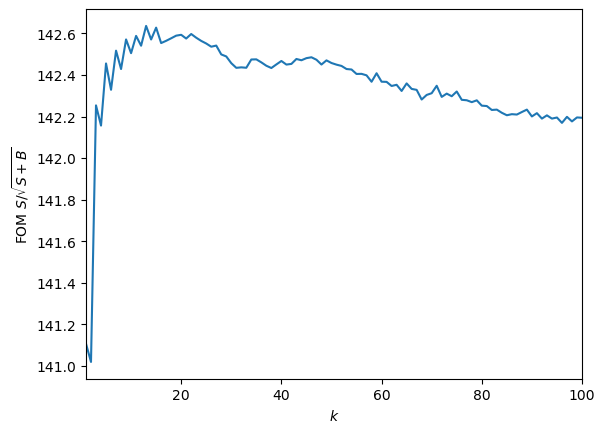

In [193]:
plt.plot(kvals,FOMvals)
plt.xlim(1,100)
plt.xlabel('$k$')
plt.ylabel(r'FOM $S/\sqrt{S+B}$')
plt.show()

In [185]:
# upper left: true positives/all pred positives: fraction of all events that were predicted to be photons that were actually photons, 
# lower left: false positives/all pred positives: fraction of all events that were predicted to be photons that were actually neutrons

confusion_matrix(y_pred=y_true_pred['predicted label'], y_true=y_true_pred['true label'], labels = ['photon', 'neutron'], normalize = 'pred')

array([[0.97534105, 0.03836236],
       [0.02465895, 0.96163764]])

In [198]:
type(sk.svm.SVC)

abc.ABCMeta

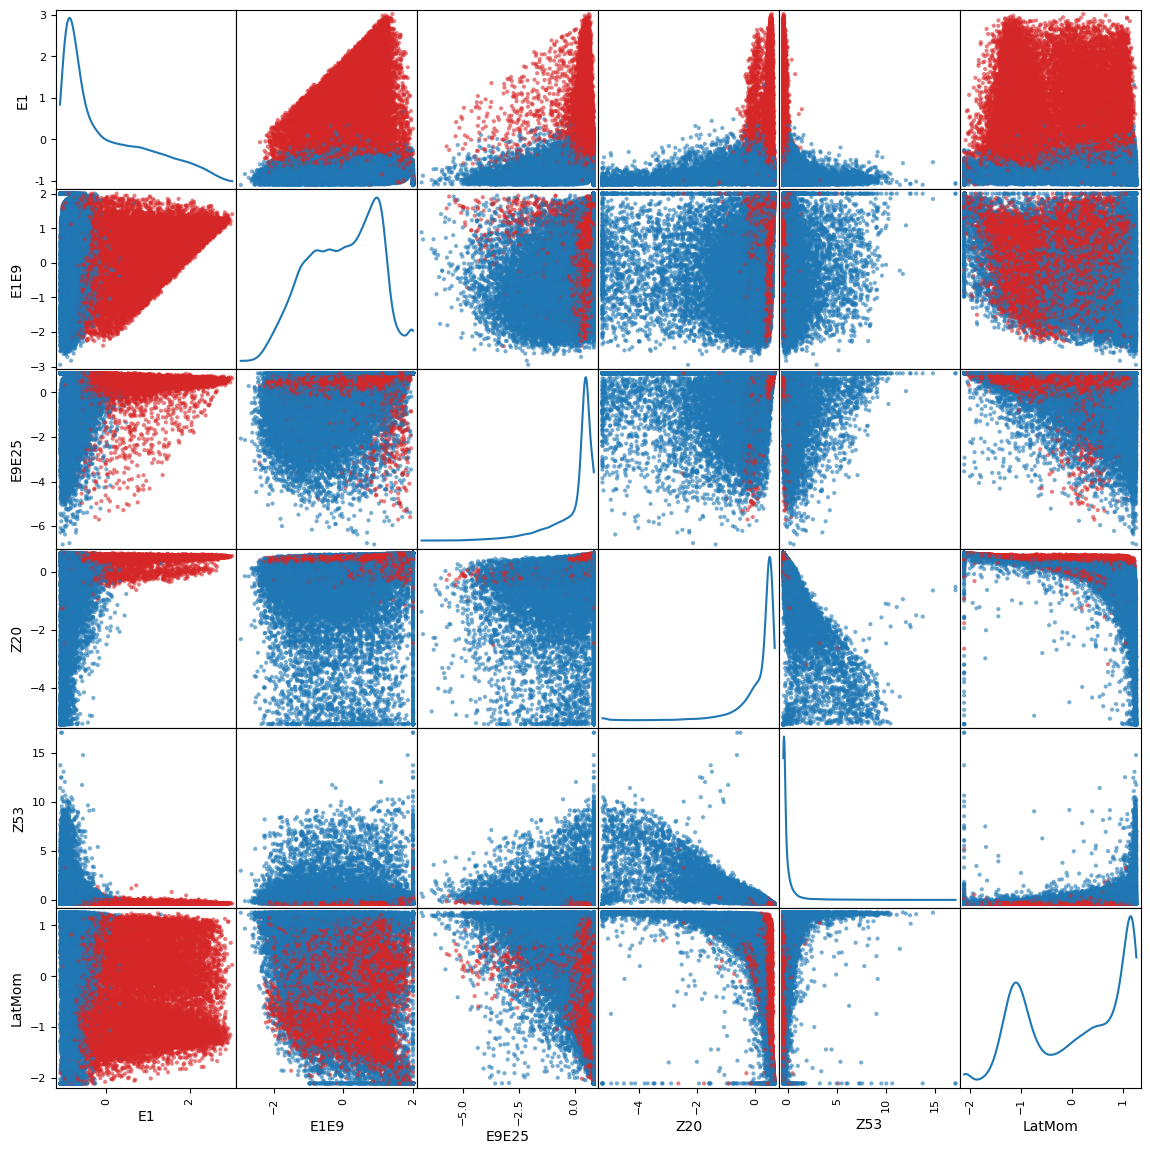

In [227]:
colors = ['tab:blue', 'tab:red',]

_ = pd.plotting.scatter_matrix(pd.DataFrame(X_test, columns=selected_features), figsize=(14,14), diagonal='kde', alpha=0.6, color=[colors[x] for x in y_test])

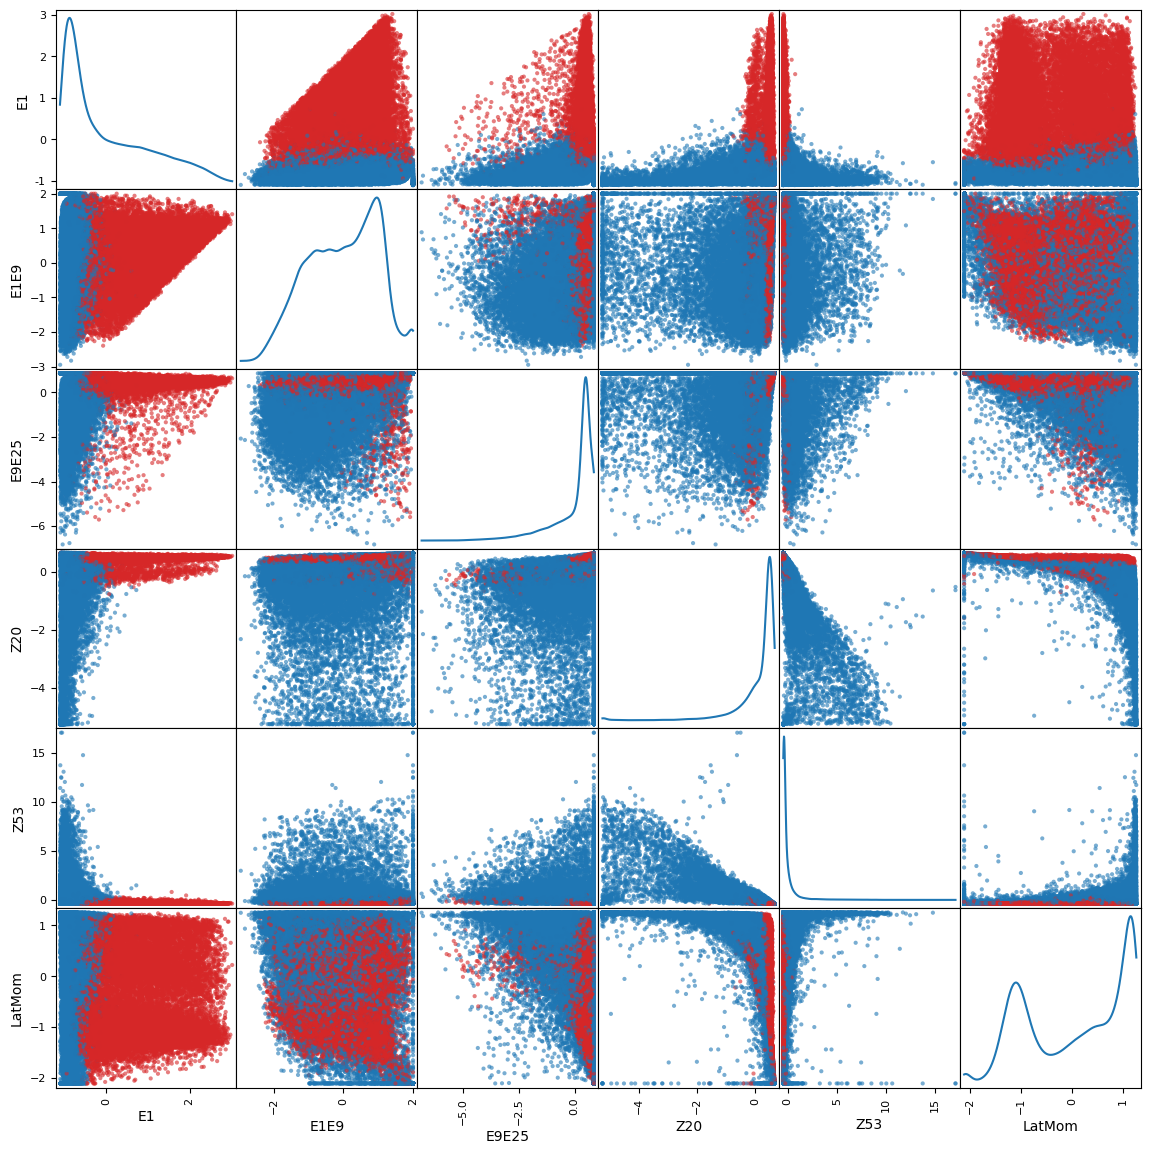

In [231]:
_ = pd.plotting.scatter_matrix(pd.DataFrame(X_test, columns=selected_features), figsize=(14,14), diagonal='kde', alpha=0.6, color=[colors[x] for x in y_true_pred['predicted label']])